Team Members

*   Libin Kutty - Group 2
*   Ritu Gahir - Group 3
*   Viju Sudhi - Group 10

In [1]:
%tensorflow_version 2.x

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split

In [11]:
def model():
  model = Sequential()

  model.add(Conv2D(32, (3, 3), input_shape=(32,32,3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(64, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(128, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

  model.add(Dense(64))
  #model.add(Activation('relu'))

  model.add(Dense(10))
  model.add(Activation('softmax'))

  return model

In [17]:
(train_imgs, train_lbls), (test_imgs, test_lbls) = tf.keras.datasets.cifar10.load_data()

train_imgs = (train_imgs.astype(np.float32) / 255.).reshape((-1, 32, 32, 3))
train_lbls = train_lbls.astype(np.int32)

test_imgs = (test_imgs.astype(np.float32) / 255.).reshape((-1, 32, 32, 3))
test_lbls = test_lbls.astype(np.int32)

batch_size = 128

train_data = tf.data.Dataset.from_tensor_slices((train_imgs, train_lbls))

train_data = train_data.shuffle(train_imgs.shape[0])
train_data = train_data.batch(batch_size)
train_data = train_data.repeat(5)


test_data = tf.data.Dataset.from_tensor_slices((test_imgs, test_lbls))
test_data = test_data.batch(batch_size)

# Generation of Adversarial Examples

    Model trained on original train data and adversarial examples is created on test data
    Loss increases when model is tested on adversaraial data when compared to original test data

In [18]:
cifar_model = model()

In [19]:
opt = tf.optimizers.Adam()

loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [20]:
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

for step, (img_batch, lbl_batch) in enumerate(train_data):
    #if step > train_steps:
    #    break

    with tf.GradientTape() as tape:
        logits = cifar_model(img_batch)
        xent = loss_fn(lbl_batch, logits)

    varis = cifar_model.trainable_variables
    grads = tape.gradient(xent, varis)

    opt.apply_gradients(zip(grads, varis))
    
    train_acc_metric(lbl_batch, logits)
    
    if not step % 100:
        print("Loss: {} Accuracy: {}".format(xent, train_acc_metric.result()))
        train_acc_metric.reset_states()

Loss: 2.306267023086548 Accuracy: 0.0859375
Loss: 2.1663479804992676 Accuracy: 0.24124999344348907
Loss: 2.143115758895874 Accuracy: 0.3323437571525574
Loss: 2.035195827484131 Accuracy: 0.3675781190395355
Loss: 2.0309062004089355 Accuracy: 0.3872333765029907
Loss: 1.9798495769500732 Accuracy: 0.40617188811302185
Loss: 2.0523767471313477 Accuracy: 0.4378906190395355
Loss: 2.000171661376953 Accuracy: 0.46773436665534973
Loss: 1.959603190422058 Accuracy: 0.4875313639640808
Loss: 1.9461708068847656 Accuracy: 0.5075781345367432
Loss: 1.9544520378112793 Accuracy: 0.5232031345367432
Loss: 1.8927922248840332 Accuracy: 0.5376562476158142
Loss: 1.849780797958374 Accuracy: 0.5403074026107788
Loss: 1.859367847442627 Accuracy: 0.5589843988418579
Loss: 1.9148237705230713 Accuracy: 0.5661718845367432
Loss: 1.961467981338501 Accuracy: 0.5739843845367432
Loss: 1.893547773361206 Accuracy: 0.585476815700531
Loss: 1.925924301147461 Accuracy: 0.6006249785423279
Loss: 1.9186731576919556 Accuracy: 0.60234373

In [23]:
for step, (imgt_batch, lblt_batch) in enumerate(test_data):

  with tf.GradientTape() as tape:
    tape.watch(imgt_batch)      
    logits = cifar_model(imgt_batch)
    xent = loss_fn(lblt_batch, logits)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(xent, imgt_batch)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.math.sign(gradient)
  
  break

In [25]:
signed_grad[0]

<tf.Tensor: shape=(32, 32, 3), dtype=float32, numpy=
array([[[-1., -1., -1.],
        [-1.,  1.,  1.],
        [-1., -1.,  1.],
        ...,
        [ 1.,  1., -1.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]],

       [[-1., -1., -1.],
        [-1., -1., -1.],
        [-1.,  1., -1.],
        ...,
        [ 1., -1., -1.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]],

       [[ 1., -1., -1.],
        [-1., -1., -1.],
        [ 1.,  1., -1.],
        ...,
        [ 1., -1., -1.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]],

       ...,

       [[ 1.,  1.,  1.],
        [-1.,  1., -1.],
        [ 1., -1.,  1.],
        ...,
        [ 1.,  1.,  1.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]],

       [[ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]],

       [[ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0

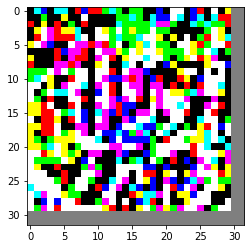

In [26]:
plt.imshow(signed_grad[0]*0.5+0.5)

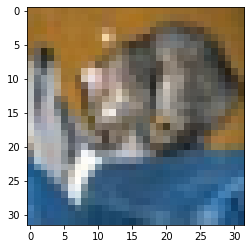

In [27]:
plt.imshow(imgt_batch[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


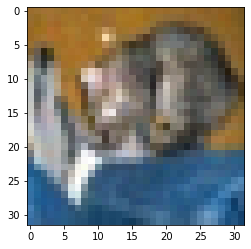

In [46]:
adv_exp = imgt_batch[0] + 0.01*signed_grad[0]
plt.imshow(adv_exp)

In [47]:
pred = cifar_model(imgt_batch)
loss_pred = loss_fn(lblt_batch, pred)

print(loss_pred)

tf.Tensor(1.828654, shape=(), dtype=float32)


In [48]:
adv_exp_batch = imgt_batch + 0.01*signed_grad

In [49]:
adv_pred = cifar_model(adv_exp_batch)
loss_pred = loss_fn(lblt_batch, adv_pred)

print(loss_pred)

tf.Tensor(2.1082363, shape=(), dtype=float32)


# Adversarial Training

With double batch training - On original and generated adversairal examples and tested on only adversarail  example


---

Adversarail training affects the performance of the original data but the loss of test data(adversarial data) has decrease a little when compared with model which was not trained with generated examples

In [61]:
adv_train_model = model()

In [62]:
for step, (img_batch, lbl_batch) in enumerate(train_data):

#First trrain with actual image
  with tf.GradientTape() as tape:
      logits = adv_train_model(img_batch)
      xent = loss_fn(lbl_batch, logits)

  varis = adv_train_model.trainable_variables
  grads = tape.gradient(xent, varis)

  opt.apply_gradients(zip(grads, varis))
#--------------------------------

  train_acc_metric(lbl_batch, logits)

  if not step % 100:
    print('Without Adversarail Examples')
    print("Loss: {} Accuracy: {}".format(xent, train_acc_metric.result()))
    train_acc_metric.reset_states()

#Generate Adversarial Example
  with tf.GradientTape() as tape1:
    tape1.watch(img_batch)      
    logits = adv_train_model(img_batch)
    xent = loss_fn(lbl_batch, logits)

  gradient = tape1.gradient(xent, img_batch)
  signed_grad = tf.math.sign(gradient)    

  train_adv_batch = img_batch + 0.01*signed_grad
#---------------------------------

#Second train with adversarial example
  with tf.GradientTape() as tape2:
    logits = adv_train_model(train_adv_batch)
    xent = loss_fn(lbl_batch, logits)

  varis = adv_train_model.trainable_variables
  grads = tape2.gradient(xent, varis)

  opt.apply_gradients(zip(grads, varis))
#---------------------------------

  train_acc_metric(lbl_batch, logits)

  if not step % 100:
    print('With Adversarial Examples')
    print("Loss: {} Accuracy: {}".format(xent, train_acc_metric.result()))
    train_acc_metric.reset_states()

Without Adversarail Examples
Loss: 2.302178382873535 Accuracy: 0.0992838516831398
With Adversarial Examples
Loss: 2.2936441898345947 Accuracy: 0.1328125
Without Adversarail Examples
Loss: 2.2337164878845215 Accuracy: 0.20999528467655182
With Adversarial Examples
Loss: 2.284864664077759 Accuracy: 0.140625
Without Adversarail Examples
Loss: 2.163830280303955 Accuracy: 0.26452574133872986
With Adversarial Examples
Loss: 2.2401692867279053 Accuracy: 0.1953125
Without Adversarail Examples
Loss: 2.039684772491455 Accuracy: 0.31312814354896545
With Adversarial Examples
Loss: 2.128347158432007 Accuracy: 0.3125
Without Adversarail Examples
Loss: 2.056955099105835 Accuracy: 0.342291921377182
With Adversarial Examples
Loss: 2.1797077655792236 Accuracy: 0.28125
Without Adversarail Examples
Loss: 1.9517382383346558 Accuracy: 0.3642430901527405
With Adversarial Examples
Loss: 2.0921273231506348 Accuracy: 0.34375
Without Adversarail Examples
Loss: 2.0290210247039795 Accuracy: 0.3698963522911072
With 

In [63]:
adv_pred = adv_train_model(adv_exp_batch)
loss_pred = loss_fn(lblt_batch, adv_pred)

print(loss_pred)

tf.Tensor(1.9150372, shape=(), dtype=float32)
